# How to use Kepler Mapper

Kepler Mapper (kmapper) is the _best_ python library for performing the mapper algorithm.

This notebook will not explain the mapper algorithm in much detail (For this, see something like [1]). Instead, this notebook explains how kmapper works, and how to use it well.

## References
[1] Singh, G., Memoli, F., Carlsson, G., _Topological Methods for the Analysis of High Dimensional Data Sets and 3D Object Recognition_, Eurographics Symposium on Point-Based Graphics, 2007

## Loading in Dataset

In this work, we will be using the example of a concentric circle dataset. We might deviate from this to discuss other features of kmapper that do not arise in this example. We encourage the user to modify the code cells in this notebook.

In [1]:
import numpy as np
np.random.seed(42)
pi = np.pi

n_circles = 3
r_circles = [1,4,9]
n_points_circle = [2000,2000,2000]
centres_circle = [[0,0],
                  [0,0],
                  [9,0]]
n_points_total = sum(n_points_circle)

coords = np.zeros((n_points_total,2))
classes = np.zeros(n_points_total, dtype=int)
point_n = 0
for circle_i in range(n_circles):
    n_points_i = n_points_circle[circle_i]
    r_i = r_circles[circle_i]
    centre = centres_circle[circle_i]
    x_i = centre[0]
    y_i = centre[1]
    for point_i in range(n_points_i):
        theta = 2*pi*np.random.random()
        x = r_i * np.cos(theta) + x_i
        y = r_i * np.sin(theta) + y_i
        coords[point_n] = [x,y]
        classes[point_n] = circle_i
        point_n += 1

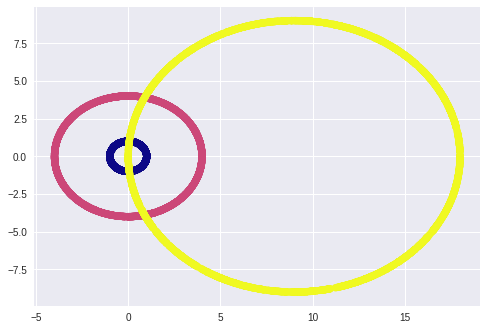

In [3]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.patches import Rectangle
%matplotlib inline
import seaborn as sns
sns.set()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(coords[:,0], coords[:,1], c=classes, cmap='plasma')
plt.show()
    

## Defining our Lens and Clusterer (and its associated metric)

Mapper requires a lens. We know kmapper is also going to require a lens. More specifically, kmapper requires the lens as a numpy array of shape `((n_points, n_dim))`, where the lens is evaluated at each point. Here, we are going to use the x-coordinate as our lens.

The algorithm also requires a clusterer. We will use dbscan. Your clustering algorithm will have its own hyperparameters, to experiment with.

We also need to define the space that the clustering will be performed in, which is then passed as a parameter to your clustering algorithm.

In practice, for kmapper, this is one of:
 - A precomputed metric `metric='precomputed'`. 
 - The _default behavoir_ of your chosen clustering algorithm when applied to your _original dataset_
 
This choice will alter the syntax used in kmapper slightly, as we will see later.

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
clusterer = DBSCAN(eps=0.5, min_samples=2)

lens = coords[:,0]

## Defining our Cover

Mapper requires a covering of our space. kmapper has currently only got an implementation of a rectangular cover. This is a series of overlapping n-dimensional rectangles. This implementation uses the following parameters:
 - `n_cubes`: The number of rectangles
 - `perc_overlap`: The overlap percentage for each rectangle. For example, if `perc_overlap=0.2`, then 10% of the bins area intersects with the subsequent bins on both sides.

If our lens is multidimensional, we have the option of either setting these parameters the same for each dimension, or we can set them to a list, with a value for each dimension.
 

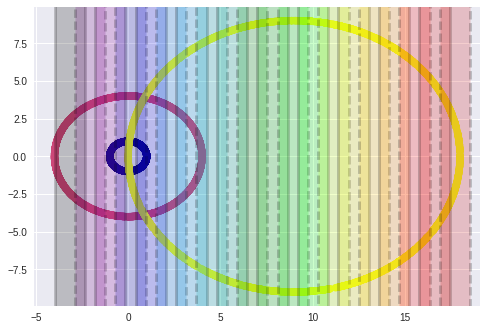

In [7]:
import kmapper as km

n_cubes = 20
perc_overlap = 0.5

cover = km.cover.Cover(n_cubes, perc_overlap)

### The following is all just for visualisation of the cover, and isn't that important

indexed_data = np.zeros((n_points_total,2))
indexed_data[:,0] = np.arange(n_points_total, dtype=int)
indexed_data[:,1] = lens

lower_edges = []
upper_edges = []
for i in cover.define_bins(indexed_data):
    lower_edges.append((cover.d+i*cover.chunk_dist)[0])
    upper_edges.append(lower_edges[-1]+cover.chunk_dist+cover.overlap_dist)
    
cmap = get_cmap('nipy_spectral')
color_fracs = np.arange(len(lower_edges), dtype=int) / len(lower_edges)
width = cover.chunk_dist+cover.overlap_dist
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(coords[:,0], coords[:,1], c=classes, cmap='plasma')
for edge_i in range(len(lower_edges)):
    if edge_i % 2 == 0:
        rect = Rectangle((lower_edges[edge_i],-12), width=width,height=24,fill=True, alpha=0.2,
                         fc=cmap(edge_i/len(lower_edges)), ec='black', linewidth=3, linestyle='-')
    else:
        rect = Rectangle((lower_edges[edge_i],-12), width=width,height=24,fill=True, alpha=0.2,
                         fc=cmap(edge_i/len(lower_edges)), ec='black', linewidth=3, linestyle='--')
    ax.add_patch(rect)
plt.show()

## Defining our color function and tooltips

This is useful for visualisation of the mapper network. We create two numpy arrays:
 - `color_function`: (n_points)
     - The nodes in the network are colored according to the average value of `color_function` of the points inside the node. If this is not set, the index of the point is used.
 - `tooltips`: (n_points,\*)
     - The cluster data pane of the output network can also contain some tooltips. If this is not set, the index of the point is used
     
In our example, we will use the class labels for our color function and tooltips

In [8]:
color_function = classes
tooltips = classes

## Putting it all together

We firstly have to initialise a mapper instance, with a verbosity:
 - 0: No output
 - 1: Moderate output
 - 2: Lots of output
 
We then use the map method to create our network.
 - `lens`: Our computed lens
 - `X`: Our input space, **_or_** our precomputed metric
 - `clusterer`: Our clustering algorithm
 - `cover`: Our defined cover
 - `precomputed`: A flag, which if true will pass the argument `metric=precomputed` to our clustering algorithm. This will cause it to expect a square matrix for `X`.

In [9]:
# initialise a mapper instance

verbosity = 1
mapper = km.KeplerMapper(verbose=verbosity)

# Map!
kmapper_complex = mapper.map(lens=lens, X=coords,
                                 clusterer=clusterer, cover=cover, precomputed=False)

KeplerMapper()
Mapping on data shaped (6000, 2) using lens shaped (6000,)

Creating 20 hypercubes.

Created 45 edges and 43 nodes in 0:00:00.225592.


## Visualisation

Currently, there is only one backend for the kmapper visualisation (although I know this is being worked on). It results in a `.html` file being saved. I know of issues when using this visualisation in centOS firefox (network does not appear), and IE (menu buttons do not work). Visualisation appears to work well using Chrome on Windows.

In [10]:
path_html = 'network.html'

_ = mapper.visualize(kmapper_complex, path_html=path_html, color_function=color_function, custom_tooltips=tooltips)

Wrote visualization to: network.html
